<a href="https://colab.research.google.com/github/lalit1511/SQL_Projects/blob/main/SQL_Brazilian_E_Commerce_Public_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

customers = pd.read_csv('olist_customers_dataset.csv', sep=',', on_bad_lines='skip')
orders = pd.read_csv('olist_orders_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')
reviews = pd.read_csv('olist_order_reviews_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')

In [2]:
import sqlite3

conn = sqlite3.connect(':memory:')

customers.to_sql('customers', conn, index=False, if_exists='replace')
orders.to_sql('orders', conn, index=False, if_exists='replace')
order_items.to_sql('order_items', conn, index=False, if_exists='replace')
products.to_sql('products', conn, index=False, if_exists='replace')
sellers.to_sql('sellers', conn, index=False, if_exists='replace')
payments.to_sql('payments', conn, index=False, if_exists='replace')
reviews.to_sql('reviews', conn, index=False, if_exists='replace')
geolocation.to_sql('geolocation', conn, index=False, if_exists='replace')


826416

In [3]:
#Show All Order Statuses and Their Counts
query = """
SELECT order_status, COUNT(*) AS total_orders
FROM orders
GROUP BY order_status
ORDER BY total_orders DESC;
"""

pd.read_sql_query(query, conn)


,order_status,total_orders
0,delivered,96478
1,shipped,1107
2,canceled,625
3,unavailable,609
4,invoiced,314
5,processing,301
6,created,5
7,approved,2


In [4]:
#Calculate the Average Delivery Time (Delivered Orders Only)
query = """
SELECT
    ROUND(AVG(JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_purchase_timestamp)), 2) AS avg_delivery_days
FROM orders
WHERE order_status = 'delivered';
"""

pd.read_sql_query(query, conn)


,avg_delivery_days
0,None


In [20]:
# Top 10 Payment Methods Used
query = """
SELECT payment_type, COUNT(*) AS total
FROM payments
GROUP BY payment_type
ORDER BY total DESC
LIMIT 10;
"""

pd.read_sql_query(query, conn)


,payment_type,total
0,credit_card,76795
1,boleto,19784
2,voucher,5775
3,debit_card,1529
4,not_defined,3


In [14]:
#Top 10 Product Categories by Quantity Sold
query = """
SELECT
    p.product_category_name,
    SUM(oi.product_id IS NOT NULL) AS items_sold
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
GROUP BY p.product_category_name
ORDER BY items_sold DESC
LIMIT 10;
"""

pd.read_sql_query(query, conn)


,product_category_name,items_sold
0,cama_mesa_banho,11115
1,beleza_saude,9670
2,esporte_lazer,8641
3,moveis_decoracao,8334
4,informatica_acessorios,7827
5,utilidades_domesticas,6964
6,relogios_presentes,5991
7,telefonia,4545
8,ferramentas_jardim,4347
9,automotivo,4235


**Section 1**

In [5]:
# Total Counts of Key Tables
# Total customers
pd.read_sql_query("SELECT COUNT(DISTINCT customer_id) AS total_customers FROM customers;", conn)


,total_customers
0,99441


In [6]:
# Total sellers
pd.read_sql_query("SELECT COUNT(DISTINCT seller_id) AS total_sellers FROM sellers;", conn)


,total_sellers
0,3095


In [7]:
# Total products
pd.read_sql_query("SELECT COUNT(DISTINCT product_id) AS total_products FROM products;", conn)


,total_products
0,32951


In [8]:
# Total orders
pd.read_sql_query("SELECT COUNT(*) AS total_orders FROM orders;", conn)


,total_orders
0,99441


In [9]:
#Order Status Distribution
pd.read_sql_query("""
SELECT order_status, COUNT(*) AS order_count
FROM orders
GROUP BY order_status
ORDER BY order_count DESC;
""", conn)


,order_status,order_count
0,delivered,96478
1,shipped,1107
2,canceled,625
3,unavailable,609
4,invoiced,314
5,processing,301
6,created,5
7,approved,2


**📦 Section 2: Order Analysis**

In [10]:
#📈 1. Orders per Month
pd.read_sql_query("""
SELECT
    STRFTIME('%Y-%m', order_purchase_timestamp) AS order_month,
    COUNT(*) AS total_orders
FROM orders
GROUP BY order_month
ORDER BY order_month;
""", conn)


,order_month,total_orders
0,None,99441


In [11]:
#🚚 2. Average Delivery Time (in Days)
pd.read_sql_query("""
SELECT
    ROUND(AVG(JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_purchase_timestamp)), 2) AS avg_delivery_days
FROM orders
WHERE order_status = 'delivered'
AND order_delivered_customer_date IS NOT NULL;
""", conn)


,avg_delivery_days
0,None


In [12]:
#❌📦 3. Canceled Orders vs Delivered Orders
pd.read_sql_query("""
SELECT
    order_status,
    COUNT(*) AS count
FROM orders
WHERE order_status IN ('delivered', 'canceled')
GROUP BY order_status;
""", conn)


,order_status,count
0,canceled,625
1,delivered,96478


In [13]:
#📉 4. Orders with Delayed Delivery (optional)
pd.read_sql_query("""
SELECT
    COUNT(*) AS delayed_orders
FROM orders
WHERE order_status = 'delivered'
AND order_delivered_customer_date > order_estimated_delivery_date;
""", conn)


,delayed_orders
0,44261


#🛍️ Section 3: Product Performance

In [15]:
#🥇 1. Top 10 Best-Selling Product Categories
pd.read_sql_query("""
SELECT
    p.product_category_name,
    COUNT(*) AS items_sold
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
GROUP BY p.product_category_name
ORDER BY items_sold DESC
LIMIT 10;
""", conn)



,product_category_name,items_sold
0,cama_mesa_banho,11115
1,beleza_saude,9670
2,esporte_lazer,8641
3,moveis_decoracao,8334
4,informatica_acessorios,7827
5,utilidades_domesticas,6964
6,relogios_presentes,5991
7,telefonia,4545
8,ferramentas_jardim,4347
9,automotivo,4235


In [16]:
#💰 2. Average Price by Product Category
pd.read_sql_query("""
SELECT
    p.product_category_name,
    ROUND(AVG(oi.price), 2) AS avg_price
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
GROUP BY p.product_category_name
ORDER BY avg_price DESC
LIMIT 10;
""", conn)


,product_category_name,avg_price
0,pcs,1098.34
1,portateis_casa_forno_e_cafe,624.29
2,eletrodomesticos_2,476.12
3,agro_industria_e_comercio,342.12
4,instrumentos_musicais,281.62
5,eletroportateis,280.78
6,portateis_cozinha_e_preparadores_de_alimentos,264.57
7,telefonia_fixa,225.69
8,construcao_ferramentas_seguranca,208.99
9,relogios_presentes,201.14


In [17]:
#🚚 3. Average Freight Value by Product Category
pd.read_sql_query("""
SELECT
    p.product_category_name,
    ROUND(AVG(oi.freight_value), 2) AS avg_freight
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
GROUP BY p.product_category_name
ORDER BY avg_freight DESC
LIMIT 10;
""", conn)


,product_category_name,avg_freight
0,pcs,48.45
1,eletrodomesticos_2,44.54
2,moveis_colchao_e_estofado,42.91
3,moveis_cozinha_area_de_servico_jantar_e_jardim,42.70
4,moveis_quarto,42.50
5,moveis_escritorio,40.55
6,portateis_casa_forno_e_cafe,36.16
7,moveis_sala,35.72
8,sinalizacao_e_seguranca,32.70
9,industria_comercio_e_negocios,29.42


In [18]:
#📦 Optional: Products with Zero Price (for data quality check)
pd.read_sql_query("""
SELECT COUNT(*) AS zero_price_items
FROM order_items
WHERE price = 0;
""", conn)


,zero_price_items
0,0


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns


📊 Visuals for Product Performance

<ipython-input-20-6ad84a87b910>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_categories, x='items_sold', y='product_category_name', palette='viridis')


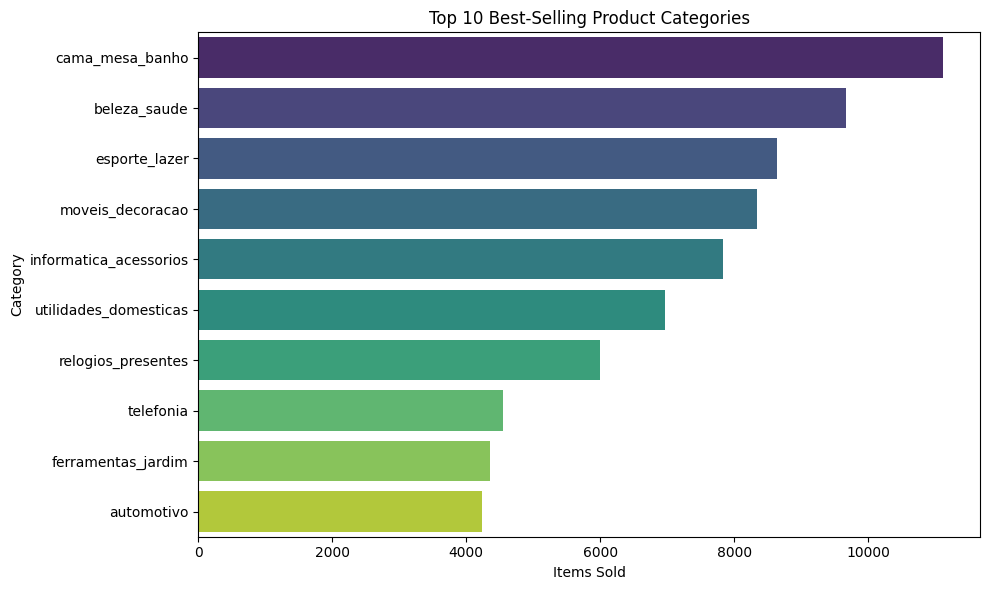

In [20]:
#📈 1. Top 10 Best-Selling Product Categories
# Get top 10 best-selling categories
top_categories = pd.read_sql_query("""
SELECT
    p.product_category_name,
    COUNT(*) AS items_sold
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
GROUP BY p.product_category_name
ORDER BY items_sold DESC
LIMIT 10;
""", conn)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_categories, x='items_sold', y='product_category_name', palette='viridis')
plt.title('Top 10 Best-Selling Product Categories')
plt.xlabel('Items Sold')
plt.ylabel('Category')
plt.tight_layout()
plt.show()


<ipython-input-21-8e15f5e1ac25>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_expensive, x='avg_price', y='product_category_name', palette='magma')


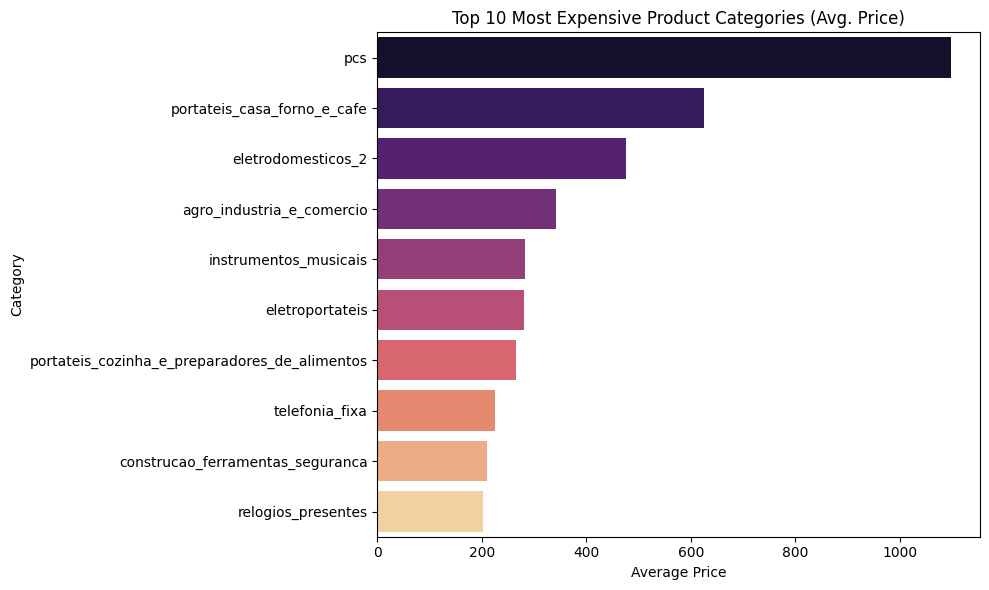

In [21]:
#💰 2. Top 10 Most Expensive Product Categories (Avg. Price)
top_expensive = pd.read_sql_query("""
SELECT
    p.product_category_name,
    ROUND(AVG(oi.price), 2) AS avg_price
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
GROUP BY p.product_category_name
ORDER BY avg_price DESC
LIMIT 10;
""", conn)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_expensive, x='avg_price', y='product_category_name', palette='magma')
plt.title('Top 10 Most Expensive Product Categories (Avg. Price)')
plt.xlabel('Average Price')
plt.ylabel('Category')
plt.tight_layout()
plt.show()


<ipython-input-22-380bedc4226d>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_freight, x='avg_freight', y='product_category_name', palette='coolwarm')


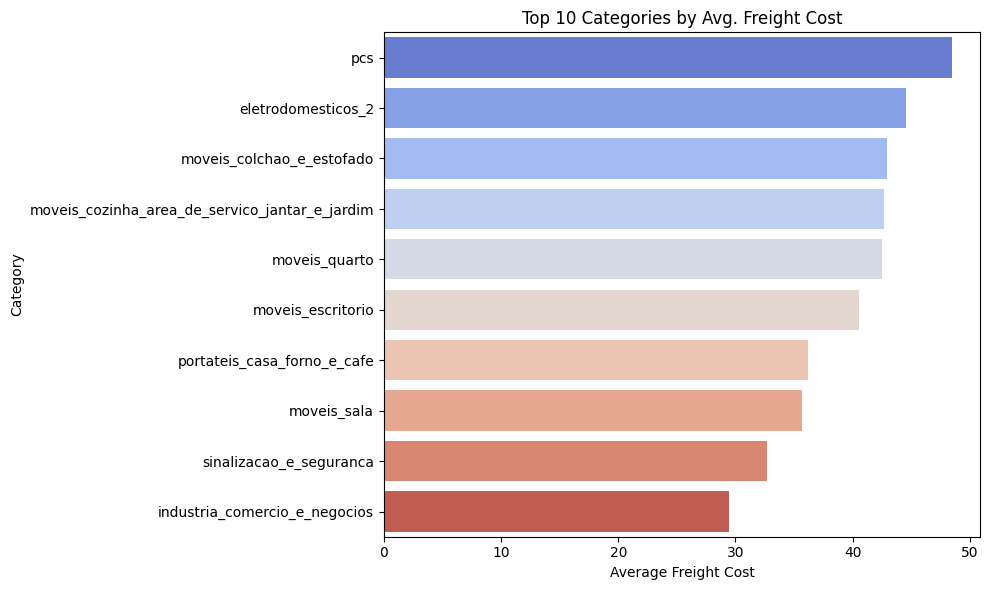

In [22]:
#🚚 3. Categories with Highest Freight Charges
top_freight = pd.read_sql_query("""
SELECT
    p.product_category_name,
    ROUND(AVG(oi.freight_value), 2) AS avg_freight
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
GROUP BY p.product_category_name
ORDER BY avg_freight DESC
LIMIT 10;
""", conn)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_freight, x='avg_freight', y='product_category_name', palette='coolwarm')
plt.title('Top 10 Categories by Avg. Freight Cost')
plt.xlabel('Average Freight Cost')
plt.ylabel('Category')
plt.tight_layout()
plt.show()


**👥 Section 4: Customer Insights**


In [23]:
#🌎 1. Top 10 States with the Most Customers
pd.read_sql_query("""
SELECT
    customer_state,
    COUNT(DISTINCT customer_id) AS total_customers
FROM customers
GROUP BY customer_state
ORDER BY total_customers DESC
LIMIT 10;
""", conn)


,customer_state,total_customers
0,SP,41746
1,RJ,12852
2,MG,11635
3,RS,5466
4,PR,5045
5,SC,3637
6,BA,3380
7,DF,2140
8,ES,2033
9,GO,2020


In [24]:
#🔁 2. Customers with Multiple Orders (Repeat Buyers)
pd.read_sql_query("""
SELECT
    COUNT(*) AS repeat_customers
FROM (
    SELECT customer_id
    FROM orders
    GROUP BY customer_id
    HAVING COUNT(order_id) > 1
);
""", conn)


,repeat_customers
0,0


In [25]:
#📦 3. Average Orders per Customer (State-wise)
pd.read_sql_query("""
SELECT
    c.customer_state,
    ROUND(COUNT(o.order_id) * 1.0 / COUNT(DISTINCT c.customer_id), 2) AS avg_orders_per_customer
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
GROUP BY c.customer_state
ORDER BY avg_orders_per_customer DESC
LIMIT 10;
""", conn)


,customer_state,avg_orders_per_customer
0,TO,1.0
1,SP,1.0
2,SE,1.0
3,SC,1.0
4,RS,1.0
5,RR,1.0
6,RO,1.0
7,RN,1.0
8,RJ,1.0
9,PR,1.0


In [26]:
#🏙️ Optional: Top Cities by Customer Count
pd.read_sql_query("""
SELECT
    customer_city,
    COUNT(DISTINCT customer_id) AS customer_count
FROM customers
GROUP BY customer_city
ORDER BY customer_count DESC
LIMIT 10;
""", conn)


,customer_city,customer_count
0,sao paulo,15540
1,rio de janeiro,6882
2,belo horizonte,2773
3,brasilia,2131
4,curitiba,1521
5,campinas,1444
6,porto alegre,1379
7,salvador,1245
8,guarulhos,1189
9,sao bernardo do campo,938


📊 Customer Insight Visualizations


<ipython-input-27-731f48d5a5ba>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_states, x='total_customers', y='customer_state', palette='Blues_r')


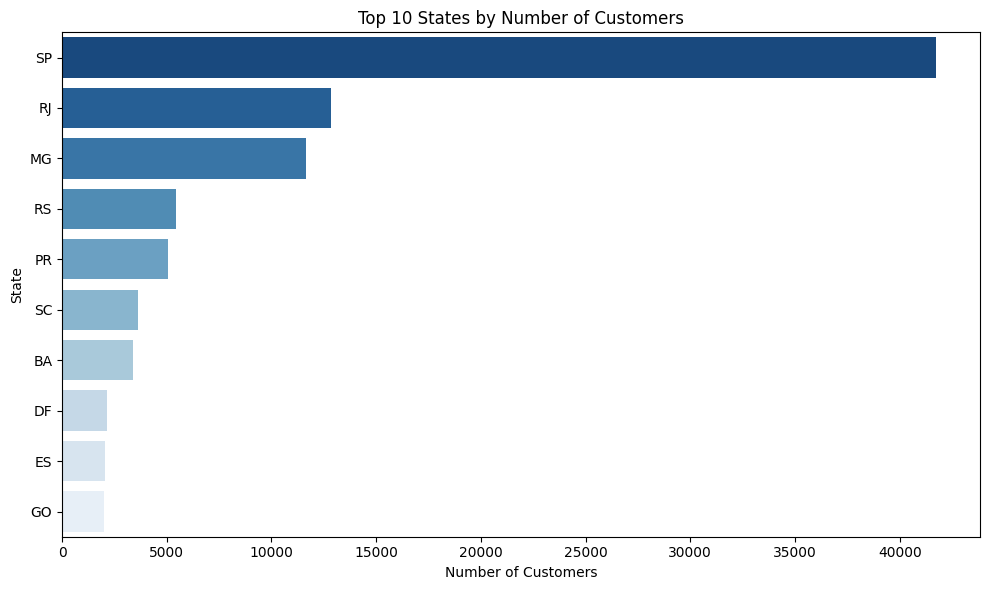

In [27]:
#🌎 1. Top 10 States by Number of Customers
top_states = pd.read_sql_query("""
SELECT
    customer_state,
    COUNT(DISTINCT customer_id) AS total_customers
FROM customers
GROUP BY customer_state
ORDER BY total_customers DESC
LIMIT 10;
""", conn)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_states, x='total_customers', y='customer_state', palette='Blues_r')
plt.title('Top 10 States by Number of Customers')
plt.xlabel('Number of Customers')
plt.ylabel('State')
plt.tight_layout()
plt.show()


<ipython-input-28-6d73a0052e01>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_orders, x='avg_orders_per_customer', y='customer_state', palette='YlGnBu')


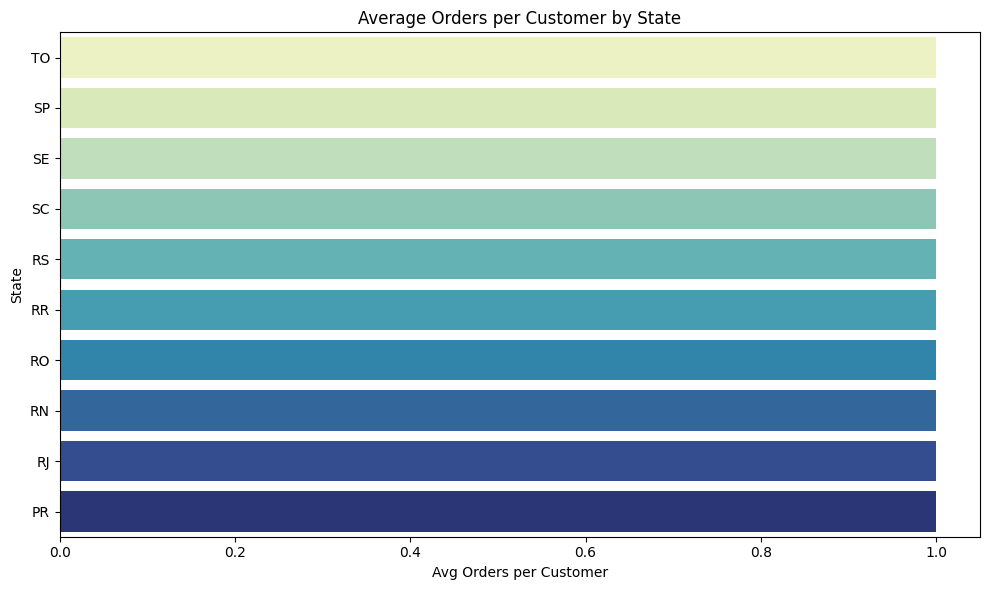

In [28]:
#🔁 2. Average Orders per Customer by State
avg_orders = pd.read_sql_query("""
SELECT
    c.customer_state,
    ROUND(COUNT(o.order_id) * 1.0 / COUNT(DISTINCT c.customer_id), 2) AS avg_orders_per_customer
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
GROUP BY c.customer_state
ORDER BY avg_orders_per_customer DESC
LIMIT 10;
""", conn)

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_orders, x='avg_orders_per_customer', y='customer_state', palette='YlGnBu')
plt.title('Average Orders per Customer by State')
plt.xlabel('Avg Orders per Customer')
plt.ylabel('State')
plt.tight_layout()
plt.show()
